In [220]:
import time
import pandas as pd
import numpy as np
import util
import pyBigWig
import seaborn as sns
import glob
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
source='data/source/'

tic=time.time()
def fix(rs):
    ratio=1
    gs=[]
    while len(gs)<len(rs):
        if len(gs)>0:
            rs=gs.copy()
        gs=[]
        skip=0
        for i in range(len(rs)-1):
            if skip==1:
                skip=0
                continue
            d0=rs[i][2]-rs[i][1]
            d1=rs[i+1][2]-rs[i+1][1]
            gap=rs[i+1][1]-rs[i][2]
            if rs[i][0]==rs[i+1][0] and d0>+ratio*gap and d1>ratio*gap:
                gs.append([rs[i][0],rs[i][1],rs[i+1][2]])
                skip=1
            else :
                gs.append([rs[i][0],rs[i][1],rs[i][2]])
        gs.append(rs[-1])
    print(len(gs))
    return pd.DataFrame(rs)
def get_cg(x):
    cg=set(range(x['b'],x['e']))
    cg=ind[x['ch']].intersection(cg)
    return cg
def hmr2df(hmr):
    gs=pd.read_table(hmr,header=None,usecols=[0,1,2])
    #gs=gs[gs[0]=='chr1']
    gs=gs[~gs[0].isin(['chrX','chrY','chrM'])]
    print(len(gs),end=',')
    #gs=fix(gs.values)
    gs.columns=['ch','b','e']   
    gs['d']=gs['e']-gs['b']
    gs['r']=gs.apply(lambda x:get_cg(x) ,axis=1)
    gs['rd']=gs.r.apply(lambda x:len(x))
    gg=gs.groupby('ch')['r'].apply(list)
    gg=gg.apply(lambda x:set.union(*x))    
    return (gs,gg)   
def get_ts(x):
    chrom=x['ch']
    com=set(range(x['b'],x['e'])).intersection(expg[chrom])
    if len(com)>0:
        ts=list(com)[0]
        ts=exp.loc[(exp['chrom']==int(chrom[3:])) & (exp.ts==ts)].index.values[0]
    else:
        ts=np.nan
    return(ts)

In [3]:
ind=pd.read_table('data/meth/h/Human_H1.meth',engine='c',usecols=[0,1],header=None)
ind=ind.groupby(0)[1].apply(list)
ind=ind.apply(lambda x:set(x))

In [4]:
samples=['s','t','h']
c={}
cg={}
cu={}
cug={}

In [5]:
for s in samples:
    c[s],cg[s]=hmr2df('data/meth/'+s+'/'+s+'.hmr')

95351,52648,39517,

In [11]:
c['t']['s']=c['t'].apply(lambda x:len(cg['s'][x['ch']].intersection(x['r'])),1)
c['t']['sh']=c['t'].apply(lambda x:len(cg['s'][x['ch']].intersection(x['r']).intersection(cg['h'][x['ch']])),1)
c['s']['t']=c['s'].apply(lambda x:len(cg['t'][x['ch']].intersection(x['r'])),1)
c['s']['th']=c['s'].apply(lambda x:len(cg['t'][x['ch']].intersection(x['r']).intersection(cg['h'][x['ch']])),1)

In [60]:
print(round(c['t']['rd'].sum()/10**3),
      round(c['t']['s'].sum()/10**3),
      round(c['t'][c['t']['s']>0]['sh'].sum()/10**3))
print(round(c['s']['rd'].sum()/10**3),
      round(c['s']['t'].sum()/10**3),
      round(c['s'][c['s']['t']>0]['th'].sum()/10**3))

2609 2352 2144
3486 2352 2144


In [61]:
print(2352-2144)

208


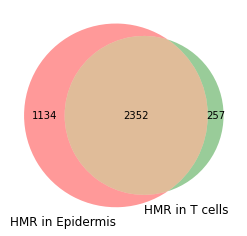

In [82]:
venn2(subsets = (3486-2352, 2609-2352, 2352), set_labels = ('HMR in Epidermis', 'HMR in T cells'))

In [69]:
for s in ['s','t']:
    for n in ['y','o']:
        path='data/meth/'+s+'/'+n+'.bw'
        bw=pyBigWig.open(path)
        c[s][n]=c[s].apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)
    c[s]['dd']=c[s]['o']-c[s]['y']
    cu[s]=c[s][c[s]['dd']>.1]
    cug[s]=cu[s].groupby('ch')['r'].apply(list)
    cug[s]=cug[s].apply(lambda x:set.union(*x))                   

In [ ]:
cu['t']['su']=cu['t'].apply(lambda x:len(cug['s'][x['ch']].intersection(x['r'])),1)
cu['t']['suh']=cu['t'].apply(lambda x:len(cug['s'][x['ch']].intersection(cg['h'][x['ch']]).intersection(x['r'])),axis=1)
cu['s']['tu']=cu['s'].apply(lambda x:len(cug['t'][x['ch']].intersection(x['r'])),1)
cu['s']['tuh']=cu['s'].apply(lambda x:len(cug['t'][x['ch']].intersection(cg['h'][x['ch']]).intersection(x['r'])),axis=1)

In [78]:
print(round(cu['t'].rd.sum()/10**3),
      round(cu['t']['su'].sum()/10**3),
      round(cu['t'][cu['t']['su']>0]['suh'].sum()/10**3))
print(round(cu['s'].rd.sum()/10**3),
      round(cu['s']['tu'].sum()/10**3),
      round(cu['s'][cu['s']['tu']>0]['tuh'].sum()/10**3))

259 27 15
95 27 15


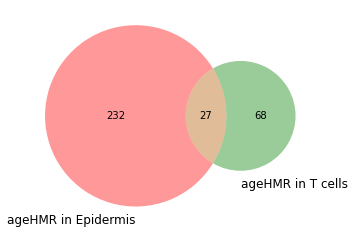

In [83]:
venn2(subsets = (259-27, 95-27, 27), set_labels = ('ageHMR in Epidermis', 'ageHMR in T cells'))

In [ ]:
bw='data/source/ENCFF109KCQ.bigWig'
bw=pyBigWig.open(bw)
ts=cu['t'][cu['t']['su']>0]
st=cu['s'][cu['s']['tu']>0]
bs=[]
for i,r in ts.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
ts['ez']=bs    
bs=[]
for i,r in st.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
st['ez']=bs    

In [195]:
print(ts[ts.suh==0].ez.mean(),ts[ts.suh>0].ez.mean())
print(st[st.tuh==0].ez.mean(),st[st.tuh>0].ez.mean())

2.892130427157452 40.63913004243051
2.9151432654522944 40.820904419018945


In [ ]:
ts['suhb']=ts['suh']>0
st['tuhb']=st['tuh']>0

<AxesSubplot:xlabel='HMR group', ylabel='ez'>

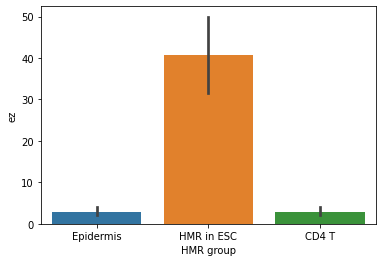

In [301]:
tst=ts.append(st[~st.tuhb])
tst.loc[tst.tuhb==False,'HMR group']='CD4 T'
tst.loc[tst.suhb==False,'HMR group']='Epidermis'
tst=tst.fillna('HMR in ESC')
sns.barplot(data=tst[['HMR group','ez']],x='HMR group',y='ez')

In [86]:
h=c['h'].copy()

In [88]:
bw='data/source/ENCFF109KCQ.bigWig'
bw=pyBigWig.open(bw)
bs=[]
for i,r in h.iterrows():
    bs.append(bw.stats(r['ch'],int(r['b']),int(r['e']),'max')[0])
h['ez']=bs

In [144]:
for s in ['s','f','t']:
    for n in ['y','o']:
        path='data/meth/'+s+'/'+n+'.bw'
        bw=pyBigWig.open(path)
        h[s+n]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)
    h[s+'d']=h[s+'o']-h[s+'y']

In [283]:
h.loc[h.ez>100,'ezg']='>100'
h.loc[(h.ez>10)&(h.ez<100),'ezg']='10-100'
h.loc[h.ez<10,'ezg']='<10'

In [293]:
pl=h[['ezg','ty','to']].melt('ezg')
pl.head(1)

,ezg,variable,value
0,<10,ty,0.003165


[Text(0.5, 0, 'EZH Binding Level'), Text(0, 0.5, 'DNA Methylation')]

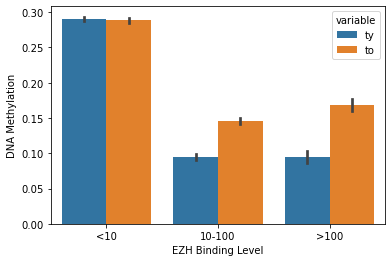

In [296]:
ax=sns.barplot(data=pl,x='ezg',y='value',hue='variable')
ax.set(xlabel='EZH Binding Level', ylabel='DNA Methylation')

In [160]:
hz=h[h.ez>100].copy()
print(len(hz),len(hz[hz.td>0]))

1035 972


In [314]:
tss=pd.read_csv('data/tss.csv',index_col=0)
exp=pd.read_csv('data/exp.csv',index_col=0)
exp['ch']='chr'+exp['chrom'].astype(str)
expg=exp.groupby('ch')['ts'].apply(list)
hz['ts']=hz.apply(lambda x: get_ts(x),axis=1)
hzt=hz[hz.ts.notna()]
len(hzt)

587

In [321]:
pl=hzt[['ty','to','ts']].melt('ts')
pl.head(1)

,ts,variable,value
0,SAMD11,ty,0.038518


In [178]:
sp=['SRR10429'+ i for i in  ['03','06','07','09','11','13']]
se=['SRR10429'+ i for i in  ['04','05','08','10','12','14']]
sep=sp+se

In [179]:
for sn in sep:
    path='data/meth/s/'+sn+'.bw'
    bw=pyBigWig.open(path)
    h[sn]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)

<AxesSubplot:xlabel='Age', ylabel='Average DNAm'>

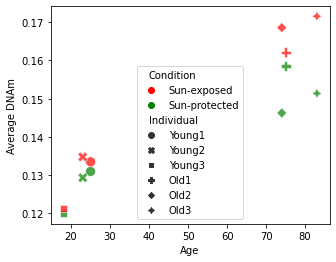

In [261]:
p=pd.DataFrame(hz[sep].mean())
p['age']=[25,23,18,75,74,83]+[25,23,18,75,74,83]
p['g']= ['Sun-protected']*6+['Sun-exposed']*6
p['indivudal']=2*['Young1','Young2','Young3','Old1','Old2','Old3']
p.columns=['Average DNAm','Age','Condition','Individual']
fig, ax = pyplot.subplots(figsize=(5,4))
sns.scatterplot(data=p,x='Age',y='Average DNAm',hue='Condition',hue_order=['Sun-exposed','Sun-protected'],
                palette=['red','green'],markers=True, style='Individual',s=100,alpha=.7)

<AxesSubplot:>

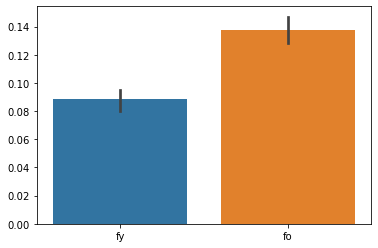

In [134]:
sns.barplot(data=hzt[['fy','fo']])